# deep learning assignment

# Import requirements

In [4]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, RepeatVector, Reshape, LSTM, Dropout, Dense, Conv2D, TimeDistributed, Activation,RepeatVector, MaxPooling2D, Flatten
import matplotlib.pyplot as plt

# Part 1: ...........................Preparing SVG code....................................

## step 1: SVG extraction and tokenization
In this substep we will focus on the following steps:
- load data
- extract data
- adding startseq and endseq in our svg examples
- Use: startseq at the beginning of SVG code
- Use: endseq at the end of the SVG code

In [32]:
path_to_train = 'C:/Users/voice/image-to-sequence-prediction/datasets/train/' 
path_to_test = 'C:/Users/voice/image-to-sequence-prediction/datasets/test/'
save_path = 'C:/Users/voice/image-to-sequence-prediction/result/'

In [8]:
def svg_extraction(my_path, svg):
    target_texts = []
    target_characters = set()
    for num in range(48000):
        num = str(num)
        file = open(my_path+'svg/'+num+".svg", 'r')
        for index, line in enumerate(file):

            if index == 1:
                target_text = 'startseq '+line+' endseq'
                target_texts.append(target_text)
                for char in target_text.split(" "):
                    if char not in target_characters:
                        target_characters.add(char)
    
    #Step 1: detect shape with the largest dimension       
    largest_shape = 0
    for x in target_texts:
        x = x.split(" ")
        all_shapes = len(x)
        if all_shapes > largest_shape:
            largest_shape = all_shapes
            
    target_characters = sorted(list(target_characters))
    num_decoder_tokens = len(target_characters)
    max_decoder_seq_length = largest_shape
    
    return target_texts, target_characters, num_decoder_tokens, max_decoder_seq_length

SVG = svg_extraction(path_to_train,'.svg')


In [9]:
target_texts, target_characters, num_decoder_tokens, max_decoder_seq_length = SVG

# Checkpoint

In [10]:
print('SVG code training examples     :', len(target_texts))
print('Number of unique output tokens :', num_decoder_tokens)
print('Max sequence length for outputs:', max_decoder_seq_length)

SVG code training examples     : 48000
Number of unique output tokens : 55
Max sequence length for outputs: 65


# step 2

- create decoder input data
- create decoder target data

In [11]:
target_token_index = dict([(word, i) for i, word in enumerate(target_characters)])
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

# step 3

- Set decoder_target_data one timestemp ahead of decoder_input_data

In [12]:
target_token_index = dict([(word, i) for i, word in enumerate(target_characters)])

decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

for i,target_text in enumerate(target_texts):
    target_text = target_text.split(" ")
    #print(i,target_text)
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index['startseq']] = 1.
    decoder_target_data[i, t:, target_token_index['startseq']] = 1.

# Checkpoint

In [13]:
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(48000, 65, 55)
(48000, 65, 55)


# Part 2: ..........................Preparing PNG images......................................

## step 1: PNG extraction and feature extraction
In this substep we want to focus on the following steps:
- load data
- extract data in an array


In [15]:
def png_extraction(file_name, svg):
    png_extract = []
    for num in range(48000):
        file = Image.open(file_name+str(num)+svg)
        file = np.asarray(file)
        png_extract.append(file)
    
    png_extract = np.array(png_extract)
    return png_extract
    file.close()
PNG = png_extraction(path_to_train+'png/','.png')

# Checkpoint

In [16]:
print(PNG.shape)

(48000, 64, 64, 4)


# Part 3: ..................................data overview.................................................

In [17]:
encoder_input_data = PNG

# Checkpoint
#### data overview
- encoder_input_data
- decoder_input_data
- decoder_target_data

In [18]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(48000, 64, 64, 4)
(48000, 65, 55)
(48000, 65, 55)


# Part 4: .....................................Build Model.................................................

- CNN: Learns features from PNG images
- LSTM: Predicts the svg code sequence

In [19]:
# Parameters for the model.
hidden_size = 128

# Process image to sequence
image_input = Input(shape=(64,64,4,))
conv_layer1 = Conv2D(16, (3, 3), activation='relu', strides=(1,1), padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2,2),strides = None, padding = 'valid')(conv_layer1)
conv_layer2 = Conv2D(16, (3, 3), activation='relu', strides=(2,2), padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2),strides = None, padding = 'valid')(conv_layer2)

flatten_layer = Flatten()(pool2)
dropout_layer = Dropout(0.5)(flatten_layer)
encoder_input = Dense(256, activation = 'relu')(dropout_layer)

encoder_inputs = RepeatVector(55)(encoder_input)
encoder_rnn_layer = LSTM(hidden_size, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_rnn_layer(encoder_inputs)
encoder_state = [state_h, state_c]

decoder_inputs = Input(shape=(None, 55))

decoder_rnn_layer = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_rnn_layer(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(55, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([image_input, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer= Adam(lr=0.0001),
                  metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   592         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   2320        max_pooling2d[0][0]              
______________________________________________________________________________________________

C:\Users\voice\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# fit model

In [20]:
cnn_lstm = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size= 64,
          epochs= 100,
          validation_split=0.2)

Epoch 1/100
600/600 [==============================] - 38s 37ms/step - loss: 1.8033 - accuracy: 0.6101 - val_loss: 1.2794 - val_accuracy: 0.7032
Epoch 2/100
600/600 [==============================] - 20s 33ms/step - loss: 1.1564 - accuracy: 0.7167 - val_loss: 1.0278 - val_accuracy: 0.7369
Epoch 3/100
600/600 [==============================] - 19s 32ms/step - loss: 0.8552 - accuracy: 0.7793 - val_loss: 0.6553 - val_accuracy: 0.8068
Epoch 4/100
600/600 [==============================] - 19s 31ms/step - loss: 0.5653 - accuracy: 0.8110 - val_loss: 0.5009 - val_accuracy: 0.8133
Epoch 5/100
600/600 [==============================] - 18s 31ms/step - loss: 0.4663 - accuracy: 0.8162 - val_loss: 0.4378 - val_accuracy: 0.8193
Epoch 6/100
600/600 [==============================] - 18s 31ms/step - loss: 0.4209 - accuracy: 0.8235 - val_loss: 0.4055 - val_accuracy: 0.8269
Epoch 7/100
600/600 [==============================] - 18s 31ms/step - loss: 0.3975 - accuracy: 0.8287 - val_loss: 0.3882 - val_ac

# plot loss and accuracy

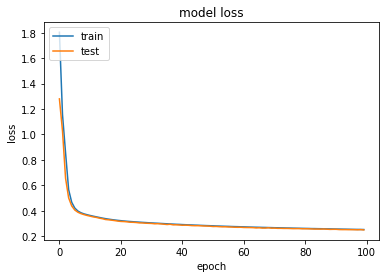

In [21]:
plt.plot(cnn_lstm.history['loss'])
plt.plot(cnn_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

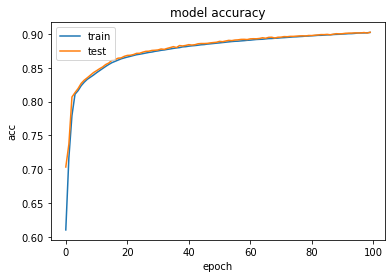

In [23]:
plt.plot(cnn_lstm.history['accuracy'])
plt.plot(cnn_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# decoder model

In [24]:
encoder_model = Model(image_input, encoder_state)

decoder_state_input_h = Input(shape=(128,))
decoder_state_input_c = Input(shape=(128,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_rnn_layer(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

## Reverse-lookup token index in order to decode sequences back to something readable.

In [25]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

# Part 5: ................................Decode sequence...........................................

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['startseq']] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    #decoded_sentence = ''
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        #decoded_sentence += sampled_char
        decoded_sentence.append(sampled_char)
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == 'endseq' or sampled_char == 'startseq' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [27]:
for seq_index in range(3):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print('-')
    print('Image input shape:', input_seq.shape)
    #print('Input sequence:', training_features[seq_index])
    print('Decoded svg code:', decoded_sentence)

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="red"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="purple"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
Image input shape:

# Part 6 ...................................Test data preparation..........................................


# step 1: load test data

In [28]:
def png_extraction(file_name, svg):
    png_extract = []
    for num in range(48000,50000):
        file = Image.open(file_name+str(num)+svg)
        file = np.asarray(file)
        png_extract.append(file)
    
    png_extract = np.array(png_extract)
    return png_extract
    file.close()
PNG_test = png_extraction(path_to_test + 'png/','.png')

# Checkpoint

In [29]:
PNG_test.shape

(2000, 64, 64, 4)

## save PNG as encoder_input_test_data

In [30]:
encoder_input_test_data = PNG_test

## decode sequence

In [31]:
decoded_predictions = []
for seq_index in range(2000):

    input_seq = encoder_input_test_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    decoded_predictions.append(decoded_sentence)

# part 7: ......................................clean output data..........................................
- remove endseq
- retrieve and append first line for all svg codes
- join all words in lists
- transform list into string

In [36]:
first_line = '<?xml version="1.0" encoding="utf-8" ?>'
clean_predictions = []
decoded_predictions[0]
for index, i in enumerate(decoded_predictions):
    #remove 'endseq'
    i = i[:-1]
    i = (" ").join(i)
    clean_predictions.append(i)

## create 2000 empty files
- create an empty file in your directory
- name it result

In [34]:
for i in range(48000,50000):
    i = str(i)
    open(save_path + i + '.svg', 'a').close()

## append codes in empty svg files

In [37]:
first_line = '<?xml version="1.0" encoding="utf-8" ?>'

count = 0
for index, code in enumerate(clean_predictions):
    index = 48000 + count
    index = str(index)
    file = open(save_path+index+'.svg', 'a')
    file.write(first_line+'\n')
    file.write(code)
    count += 1
    
file.close()